# Double Duelling Deep Q Learning

Q: The expected future rewards discounted over time.

Q is learned through the Bellman equation, where the Q of any state and action is the immediate reward achieved + the discounted maximum Q value (the best action taken) of next best action, where gamma is the discount rate.

$$Q(s,a)=r + \gamma.maxQ(s',a')$$

## General method for Q learning:

Overall aim is to create a neural network that predicts Q. Improvement comes from improved accuracy in predicting 'current' understood Q, and in revealing more about Q as knowledge is gained (some rewards only discovered after time). 
    
    
    1)  Initial parameters for Q(s,a) with random weights
    2)  With reducing probability select a random action, or best current  action, argmax Q(s,a). 
    3)  Execute action a, and observe reward r and next state s'.
    4)  Store transition (s,a,r,s') in the 'memory'
    5)  Sample random minibatch of transitions from the memory. Random sampling from the replay buffer avoids autocorrelation problems that can occur if using current state net
    6)  For every transition in the buffer, calculate y=r if the episode has ended at this step, or y=r + gamma(max Q) from target network otherwise
    7)  Update Q(s,a) in policy network by minimising the loss in respect to model parameters (taking target Q from the target network)
    8)  Repeat from (2)
    9)  Every n steps update weights in target network from the policy network
    

Target networks are used to stabilise models, and are only updated at intervals. Changes to Q values may lead to changes in closely related states (i.e. states close to the one we are in at the time) and as the network tries to correct for errors it can become unstable and suddenly lose signficiant performance. Target networks (e.g. to assess Q) are updated only infrequently (or gradually), so do not have this instability problem.

## Difference between standard and double DQL

Double DQN contains two networks. This ammendment is to decouple training of Q for current state and next state which are closely correlated when comparing input features.

The *policy network* is used to select action (action with best predicted Q) when playing the game.

When training, the predicted best *action* (best predicted Q) is taken from the *policy network*, but the *policy network* is updated using the predicted Q value of the next state from the *target network* (which is updated from the policy network less frequently). So, when training, the action is selected using Q values from the *policy network*, but the the *policy network* is updated to better predict the Q value of that action from the *target network*. The *policy network* is copied across to the *target network* every *n* steps (e.g. 1000).

Compared with our previous DQN model, we also create a single separate memory, rather than it being a component of the neural net.

## Difference between double DQL and duelling DDQN

In standard DQN we estimate Q for each action in a single step. In duelling DQN we estimate the value of the state (the mean of all action Q) and the advantage of each action (the difference in Q compared to the average Q) as separate heads in the network, and then aggregate them so Q = value + advantage

![](./images/duelling_dqn.png)

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim

from collections import deque

In [2]:
# Set up environment
ENV_NAME = "CartPole-v0"
DISPLAY_ON_SCREEN = False
# Discount rate of future rewards
GAMMA = 0.99
# Learing rate for neural network
LEARNING_RATE = 0.001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 5000
# Sample batch size for policy network update
BATCH_SIZE = 5
# Number of game steps to play before starting training
SYNC_TARGET_STEPS = 100
# Number of steps between target network update
REPLAY_START_SIZE = 1000
# Exploration rate (episolon) is probability of choosign a random action
EXPLORATION_MAX = 1.000
EXPLORATION_MIN = 0.000
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.995
# Target rewards
TARGET_REWARD = 200
# Number of times target must be met without break
TARGET_PERIOD = 5
# Set number of parallel networks
NUMBER_OF_NETS = 5

In [3]:
class DQN(nn.Module):

    """Deep Q Network. Udes for both policy (action) and target (Q) networks."""

    def __init__(self, observation_space, action_space):
        """Constructor method. Set up neural nets."""

        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX
        
        # Set up action space (choice of possible actions)
        self.action_space = action_space
              
        super(DQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(observation_space, 128),
            nn.ReLU()
            )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_space)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )        
        

    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
            
        else:
            # Otherwise get predicted Q values of actions
            q_values = self.forward(torch.FloatTensor(state))
            # Get index of action with best Q
            action = np.argmax(q_values.detach().numpy()[0])
        
        return  action
        
  
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        action_q = value + advantage  - advantage.mean()
        return action_q

In [4]:
class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=MEMORY_SIZE)

    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [5]:
def optimize(policy_net, target_net, memory):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < BATCH_SIZE:
        return    
 
    # Reduce exploration rate
    policy_net.exploration_rate *= EXPLORATION_DECAY
    policy_net.exploration_rate = max(EXPLORATION_MIN, 
                                      policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = random.sample(memory, BATCH_SIZE)
    for state, action, reward, state_next, terminal in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
       
        if not terminal:
            # For non-terminal actions get Q from policy net
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get next state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get targen net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent target net gradients being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (GAMMA * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward

        # Update neural net
        
        # Set network to training mode
        policy_net.train()
        # Reset net gradients
        policy_net.optimizer.zero_grad()  
        # calculate loss
        loss_v = nn.MSELoss()(state_action_values, expected_state_action_values)
        # Backpropogate loss
        loss_v.backward()
        # Update network gradients
        policy_net.optimizer.step()  

    return

In [6]:
def plot_results(run, exploration, score):
    """Plot results at end of run"""
    
    # Set up chart (ax1 and ax2 share x-axis)
    fig = plt.figure(figsize=(6,6,))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    
    # Plot results
    ax1.plot(run, exploration, label='exploration', color='g')
    ax2.plot(run, score, label='score', color='r')
    
    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('exploration', color='g')
    ax2.set_ylabel('score', color='r')
    
    # Show
    plt.show()

In [7]:
def cartpole():
    """Main program loop"""
    
    # Set up game environemnt
    env = gym.make(ENV_NAME)
    
    # Get number of observations returned for state
    observation_space = env.observation_space.shape[0]
    
    # Get number of actions possible
    action_space = env.action_space.n
    
    # Set up policy and target neural nets
    policy_nets = [DQN(observation_space, action_space)
                   for i in range(NUMBER_OF_NETS)]
    target_nets = [DQN(observation_space, action_space)
                   for i in range(NUMBER_OF_NETS)]
    
    # Set optimizer, copy weights from policy_net to target, and 
    for i in range(NUMBER_OF_NETS):
        # Set optimizer
        policy_nets[i].optimizer = optim.Adam(
            params=policy_nets[i].parameters(), lr=LEARNING_RATE)
        # Copy weights from policy -> target
        target_nets[i].load_state_dict(policy_nets[i].state_dict())
        # Set target net to eval rather than training mode
        target_nets[i].eval()     
    
    # Set up memomry
    memory = Memory()
    
    # Set up run counter and learning loop    
    run = 0
    all_steps = 0
    continue_learning = True
    
    # Set up list for results
    results_run = []
    results_exploration = []
    results_score = []
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        # Increment run (episode) counter
        run += 1
        
        # Start run and get first state observations
        state = env.reset()
        
        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])
        
        # Reset step count for episode
        step = 0
        
        # Continue loop until episode complete
        while True:
            
            # Incrememnt step counts
            step += 1
            all_steps += 1
            
            # Get actions to take (use evalulation mode)
            actions = []
            for i in range(NUMBER_OF_NETS):
                policy_nets[i].eval()
                actions.append(policy_nets[i].act(state))
                
            # Randomly choose an action from net actions
            random_index = random.randint(0, NUMBER_OF_NETS - 1)
            action = actions[random_index] 
            
            # Act
            state_next, reward, terminal, info = env.step(action)
            
            # Update display if needed
            if DISPLAY_ON_SCREEN:
                env.render()
            
            # Convert step reward to negative if end of run
            reward = reward if not terminal else -reward
            
            # Get observations for new state
            state_next = np.reshape(state_next, [1, observation_space])
            
            # Record state, action, reward, new state & terminal
            memory.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            # Actions to take if end of game episode
            if terminal:
                # Get exploration rate
                exploration = policy_nets[0].exploration_rate
                # Clear print row content
                clear_row = '\r' + ' '*79 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run}, ', end='')
                print (f'exploration: {exploration: .3f}, ', end='')
                print (f'score: {step}', end='')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(exploration)
                results_score.append(step)
                
                # Get average of last 5 games
                if len(results_score) >= TARGET_PERIOD:
                    average_reward = np.mean(results_score[-TARGET_PERIOD:])
                    # Stop if target met in all required episodes
                    if average_reward >= TARGET_REWARD:
                        # Stop learning loop
                        continue_learning = False
                # End episode loop
                breaktinue_learning = False
                break
            
            # Avoid training model if memory is not of sufficient length
            if len(memory.memory) < REPLAY_START_SIZE:
                continue
        
            # Update policy net
            for i in range(NUMBER_OF_NETS):
                optimize(policy_nets[i], target_nets[i], memory.memory)
            
            # Update the target network at intervals
            if all_steps % SYNC_TARGET_STEPS == 0:
                for i in range(NUMBER_OF_NETS):
                    target_nets[i].load_state_dict(
                        policy_nets[i].state_dict())
                
     # Target reached. Plot results
    plot_results(results_run, results_exploration, results_score)

Run: 74, exploration:  0.000, score: 200                                       

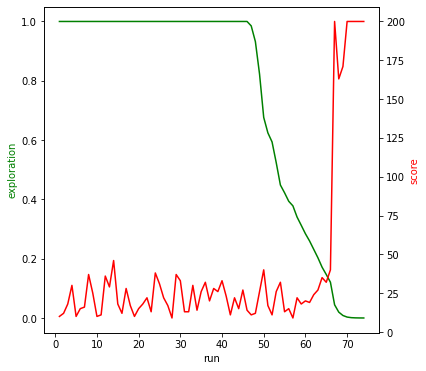

In [8]:
cartpole()